<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SingleSubjectSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per subject

### Mount Google Drive and clone repository
- open to source directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


Cloning into 'teambrainiac'...
remote: Enumerating objects: 943, done.
remote: Counting objects: 100% (943/943), done.
remote: Compressing objects: 100% (704/704), done.
remote: Total 943 (delta 596), reused 437 (delta 223), pack-reused 0
Receiving objects: 100% (943/943), 76.92 MiB | 30.53 MiB/s, done.
Resolving deltas: 100% (596/596), done.
/content/teambrainiac/source
access_data.py			  models
AccuracyMeasures.ipynb		  process.py
analysis.py			  SingleSubjectSVM.ipynb
cross_validation.py		  SubjectVisualization_Models_ZNORM.ipynb
data				  SVM_Group_Adolescent_Whole_brain.ipynb
DataExploration_SingleSubj.ipynb  SVM_Group_YA_Whole_brain.ipynb
DataExplorationVisuals.ipynb	  TestMask.ipynb
DL				  Timeseries_Cross_Validation.ipynb
Explore_data.ipynb		  train.py
Group_All_MASK_SVM.ipynb	  utils.py
helper				  VisualizationPlayground.ipynb
Images				  Visualize_Data.ipynb
__init__.py			  visualize.py


### Load path_config.py 
- we are already in source so we can just load this file without changing directory

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [5]:

# Import libraries
!pip install boto3 nilearn nibabel #for saving data and image visualizations
import pickle
#sklearn packages needed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, auc, recall_score, precision_score,roc_curve,f1_score
#important utility functions for loading,masking,saving data
#from utils import *
from access_data import *
from process import *
#normal python packages we use
import numpy as np
import pandas as pd


     |████████████████████████████████| 132 kB 37.6 MB/s 
     |████████████████████████████████| 10.1 MB 69.5 MB/s 
     |████████████████████████████████| 79 kB 10.2 MB/s 
     |████████████████████████████████| 8.7 MB 63.8 MB/s 
     |████████████████████████████████| 138 kB 74.5 MB/s 
     |████████████████████████████████| 127 kB 80.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Get paths to subject data and grab labels for SVM

In [6]:

## load and open the pickle file that contains paths to all data.
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)

###Functions to get information about data to run our SVM

In [7]:
def get_subj_information(data_path_dict):
  """
    Function to get subject information.
    data_path_dict  : dictionary containing paths to all data stored on AWS
    returns:  subject_ids(list of subjects to run),subj_paths(paths to subject raw data)
  """
  subject_ids = data_path_dict['subject_ID'] #subject_ids
  subj_paths = data_path_dict['subject_data'] #subject_paths
  return subject_ids,subj_paths

def get_labels(data_path_dict):
  """
    Function to get the labels for our data.
    data_path_dict  : dictionary containing paths to all data stored on AWS
    returns: mask_labels_indices(timepoints we want masked out),binary_labels(labels for our for our two brain states)
             and label_type
  """
  
  label_data_path = data_path_dict['labels'][0] #get labels
  label_type = 'rt_labels' #tell the function what labels we want
  mask_labels_indices, binary_labels = labels_mask_binary(label_data_path, label_type) #grab indices and labels
  return mask_labels_indices, binary_labels,label_type

def get_mask(mask_type,data_path_dict,mask_ind):
  """
    Function to return the mask of what brain voxels we want to include in analysis
    data_path_dict  : dictionary containing paths to all data stored on AWS
    mask_type: name of mask we want to use
    mask_ind: index of where the path to the masks are 0: full brain mask plus masks that subtract region
              1: Regions of interest(ROIs) mask out full brain except structure we care about
  """
  mask_data_filepath = data_path_dict['mask_data'][mask_ind] #path to masked data     
  mask_type_dict = access_load_data(mask_data_filepath, True) #get the mask data dictionary
  np_array_mask = mask_type_dict[mask_type] #get the mask array
  mask = np.ma.make_mask(np_array_mask).reshape(79*95*79,order='F') #create a 1-D array for the mask. Important to use Fourier Transformation as we are working in brain space!

  return mask

In [8]:
mask_data_filepath = data_path_dict['mask_data'][0] #path to masked data  
mask_type_dict = access_load_data(mask_data_filepath, True)


dict_keys(['__header__', '__version__', '__globals__', 'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'])

## Set up SVM Model

In [9]:
def load_subject_data(subj_paths,subject_ids,idx,mask,mask_labels_indices,binary_labels,label_type):
  """
    Function to load indivdual subject data. Calls masking data which is in utils.py
      subj_paths  :paths to subject data
      subject_ids :list of subjects
      idx   : index of current subject
      dopsc : If True, do percent signal change before returning user_data_dict
      mask  : mask to use on subject
      mask_labels_indices : indices of brain volumes we want to keep (aligning to increase/decrease)
      binary_labels: labels of increase/decrease to append to user dictionary
      label_type: type of label we are applying
      returns: user data dictionary that contains all four runs masked to just keep voxels of interest along with labels
               along with the subjects id
  """
  mat_path = subj_paths[idx] #get raw data path
  sub_id = subject_ids[idx] #get subject id
  data = access_load_data(mat_path,True) #call function to load data and return a dictionary. We are loading .mat files so need to set second param to True
  user_data_dict = {} #create empty dict
  user_data_dict[sub_id], bi_lb = masking_data(data, mask, mask_labels_indices, binary_labels, do_norm=False) #call function to mask the data and do normalization if desired
  user_data_dict[f"{sub_id}_{label_type}"] = bi_lb #set the binary labels for our data (0 = decrease,1=increase)
  return user_data_dict,sub_id

In [10]:
def scale_data_single_subj(sub_data,sub_labels, runs_train,runs_test,norm):
  """
    Function to scale data. Flexible to accomadate multiple different schemas to test which normalization is best.
      sub_data     : (1 subject data, keys as subject ID for frmi data or labels)
      sub_labels   : sub_labels to indicate which row of the sub_data belongs to increase/decrease state
      runs_train   : tuple , (which run are we using for the training data)
                            If runs_test = 1, there will be no X_val, y_val
      runs_test    : tuple, (which run are we using for the test data)
      norm         : string, ("RUNS": normalizing separately on each run;
                              "SUBJECT": Normalizing separately by each subject)
      returns      : nd.arrays, Concatenated X data of (time points, x*y*z) x = 79, y = 95, z = 75
                    and Concatenated y labels of (time points,)
    """

  # train and labels
  X = []
  y = []
  ##val and labels
  Xv = []
  yv = []
  # TEST and labels
  Xt = []
  yt = []
  ## decide how to concatenate runs
  if len(runs_train)>1:
      for run in runs_train:
        X.append(sub_data[run])
        y.append(sub_labels[run])
      
      X = np.concatenate(np.array(X))
      y = np.concatenate(np.array(y))
  else:
      X = sub_data[runs_train[0]-1]
      y = sub_labels[runs_train[0]-1]
  if len(runs_test)> 1:
      Xv = sub_data[runs_test[0]-1]
      yv = sub_labels[runs_test[0]-1]
      Xt = sub_data[runs_test[1]-1]
      yt = sub_labels[runs_test[1]-1]
  else:
      Xt = sub_data[runs_test[0]-1]
      yt = sub_labels[runs_test[0]-1]
  ##run standardization
  if norm == "ZNORM":
      scalar = StandardScaler()
      X = scalar.fit_transform(X)
      scalarT = StandardScaler()
      Xt = scalarT.fit_transform(Xt)
      if len(Xv)>0:
        Xv = scalarT.fit_transform(Xv)
  elif norm == "PSC":    
      X = clean(X,standardize='psc')
      Xt = clean(Xt,standardize='psc')
      if len(Xv)>0:
        Xv = clean(Xv,standardize='psc')
  else:
      print('Not doing standardization')       
  return X, y, Xt, yt, Xv, yv

In [11]:
def get_predicts(clf,X_test,X_val):
  """
    Function to get accuracy scores for subject models.
    Params:
      model_dict: contains subject model and training/test/val/data
      subj: subject name 
    returns: y_val_predicts(if validation run),y_test_predicts
  """
  if len(X_val)>0: #if validation data
    y_val_predicts = clf.predict(X_val) #predict val
    y_val_proba = clf.predict_proba(X_val) #predict proba
  else:
    y_val_predicts = 0 #empty if val doesn't exist
    y_val_proba = 0
  y_test_predicts = clf.predict(X_test) #predict test
  y_test_proba = clf.predict_proba(X_test) #predict proba
  return y_val_predicts,y_val_proba,y_test_predicts,y_test_proba

In [12]:
def run_single_subject_svm(sub_data,sub_labels,runs_train,runs_test,norm_type="NONORM",do_cv=False):
  """
    Function to run cross-validation or single subject SVM
      sub_data     : (1 subject data, keys as subject ID for frmi data or labels)
      sub_labels   : sub_labels to indicate which row of the sub_data belongs to increase/decrease state
      runs_train   : tuple , (which run are we using for the training data)
                            If runs_test = 1, there will be no X_val, y_val
      runs_test    : tuple, (which run are we using for the test data)
      norm         : string, ("RUNS": normalizing separately on each run;
                              "SUBJECT": Normalizing separately by each subject
                              "none: no normalization will be done)
      do_cv:       : If True, run cross-validation
      returns      : subject individual model, Training data/labels, Val data/labels, Test data/labels
  """
  
  #get scaled data
  X_train, y_train, X_test, y_test, X_val, y_val = scale_data_single_subj(sub_data,sub_labels,runs_train,runs_test,norm_type)
  #run cv if do_cv = True, else run individual model SVM
  if do_cv:
    c_params = {'C':[0.7, 1, 5, 10],'kernel':['linear', 'rbf']}
    svc = SVC()
    clf = GridSearchCV(svc, c_params)
    clf.fit(X_train, y_train)
    return clf
  else:
    clf = SVC(probability=True)
    clf.fit(X_train,y_train)
  y_val_predicts,y_val_proba,y_test_predicts,y_test_proba = get_predicts(clf,X_test,X_val)
  return clf,X_train,y_train,y_val_predicts,y_val_proba,y_test_predicts,y_test_proba

In [13]:

def run_subject_model(data_path_dict,path,file_name,runs_train,runs_test,mask_type,mask_ind,norm_type='NONORM'):
  """
    Function loops over subjects to grap data,scale,data,and run the SVM.
    data_path_dict  : dictionary containing paths to all data stored on AWS
    path : path to save pickle files. NOTE: If run on all subjects, this will take up about 20 GB
    file_name : name of file to prepend to subject id
    runs_train: what runs do we want to train on
    runs_test: what runs do we want to test on
    mask_type: which type of brain mask do we want to apply
    mask_ind: to distinguish between ROI regions of masking(1) and full brain(or full_brain minus ROIs)(0)
    do_psc: do we want to apply Percent Signal Change normalization. Default = True,
    norm: Takes three parameters: none(no normalization will be applied),"SUBJECT"(apply normalization per subject)
          "RUNS"(apply normalization per run separately)
  """
  single_model_path = {}
  #get subject information
  subject_ids,subj_paths = get_subj_information(data_path_dict)
  print(len(subject_ids))
  #get mask labels to only retrieve time series we care about
  mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict)
  #get mask to mask out voxels we don't need
  mask = get_mask(mask_type,data_path_dict,mask_ind)
  #loop over subjects
  for idx in range(len(subject_ids)):
    model_dict = {}
    user_data_dict, sub_id = load_subject_data(subj_paths,subject_ids,idx,mask,mask_labels_indices,binary_labels,label_type)
    sub_data = user_data_dict[sub_id]
    sub_labels = user_data_dict[f"{sub_id}_rt_labels"]
    clf,X_train,y_train,y_val_predicts,y_val_proba,y_test_predicts,y_test_proba = run_single_subject_svm(sub_data,sub_labels,runs_train,runs_test,norm_type)
    model_dict[sub_id] = {}
    model_dict[sub_id]['model'] = clf
    model_dict[sub_id]['X_train'] = X_train
    model_dict[sub_id]['y_train'] = y_train
    model_dict[sub_id]['y_test_predicts'] = y_test_predicts
    model_dict[sub_id]['y_test_proba'] = y_test_proba
    if len(y_val_predicts)>0:
      model_dict[sub_id]['y_val_predicts'] = y_val_predicts
      model_dict[sub_id]['y_val_proba'] = y_val_proba
    destination_path = f'{path}{file_name}{sub_id}.pkl'     
    single_model_path[sub_id] = destination_path
    # filehandler = open(destination_path,"wb") #comment out this
    # pickle.dump(model_dict,filehandler) #comment out this
    # filehandler.close() #comment out this
    object_name = destination_path
    s3_upload(model_dict,object_name,"pickle")
  object_name = f'{path}{mask_type}_data_path_dict.pkl'
  s3_upload(single_model_path,object_name,"pickle")
  # filehandler = open(object_name,"wb") #comment out this
  # pickle.dump(single_model_path,filehandler) #comment out this
  # filehandler.close() #comment out this
  return model_dict

In [14]:
mask_type_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'])

In [ ]:
save_data_path = 'models/single/model_wbsubAI/'
file_name = 'one_run_model_znorm_wbsubAI_'
file_name_dict = run_subject_model(data_path_dict,save_data_path,file_name,(2,),(3,4),'masksubAI',0,norm_type='ZNORM')


52


100%|██████████| 4/4 [00:00<00:00,  7.65it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10004_08693.pkl


100%|██████████| 4/4 [00:00<00:00,  8.11it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10008_09924.pkl


100%|██████████| 4/4 [00:00<00:00,  7.35it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10009_08848.pkl


100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10016_09694.pkl


100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10017_08894.pkl


100%|██████████| 4/4 [00:00<00:00,  7.95it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10018_08907.pkl


100%|██████████| 4/4 [00:00<00:00,  6.72it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10021_08839.pkl


100%|██████████| 4/4 [00:00<00:00,  7.53it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10022_08854.pkl


100%|██████████| 4/4 [00:00<00:00,  8.49it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10023_09126.pkl


100%|██████████| 4/4 [00:00<00:00,  8.35it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10027_09455.pkl


100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10033_08871.pkl


100%|██████████| 4/4 [00:00<00:00,  7.87it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10034_08879.pkl


100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10035_08847.pkl


100%|██████████| 4/4 [00:00<00:00,  7.61it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10036_09800.pkl


100%|██████████| 4/4 [00:00<00:00,  8.46it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10037_09903.pkl


100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10038_09063.pkl


100%|██████████| 4/4 [00:00<00:00,  8.96it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10039_08941.pkl


100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10042_08990.pkl


100%|██████████| 4/4 [00:00<00:00,  6.96it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10043_09222.pkl


100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10045_08968.pkl


100%|██████████| 4/4 [00:00<00:00,  7.11it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10046_09216.pkl


100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10047_09030.pkl


100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10050_09079.pkl


100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10053_09018.pkl


100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10056_09615.pkl


100%|██████████| 4/4 [00:00<00:00,  6.75it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10057_10124.pkl


100%|██████████| 4/4 [00:00<00:00,  8.00it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10060_09359.pkl


100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10061_09308.pkl


100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10065_09587.pkl


100%|██████████| 4/4 [00:00<00:00,  8.22it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10066_09687.pkl


100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10069_09785.pkl


100%|██████████| 4/4 [00:00<00:00,  7.64it/s]


upload complete for models/single/model_wbsubAI/one_run_model_znorm_wbsubAI_10080_09931.pkl


100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


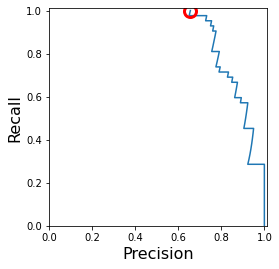

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

#logreg = LogisticRegression().fit(X_train,y_train)
#y_proba_logreg = LogisticRegression().fit(X_train,y_train).predict_proba(X_test)
#r = LogisticRegression().fit(X_train,y_train)
#lr.classes_
precision,recall,thresholds = precision_recall_curve(file_name_dict['10033_08871']['y_train'],file_name_dict['10033_08871']['y_test_proba'][:,1])
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


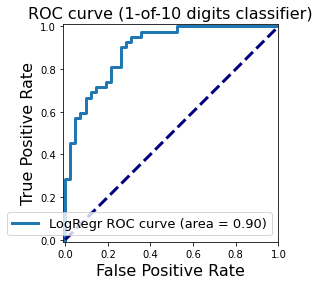

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, thresholds = roc_curve(file_name_dict['10033_08871']['y_train'],file_name_dict['10033_08871']['y_test_proba'][:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [ ]:
def run_subject_model_cv(subject_ids, runs_train,runs_test,do_psc=True,norm='none'):
  cv_dict = {}
  for idx in range(len(subject_ids)):
    model_dict = {}
    user_data_dict, sub_id = load_subject_data(idx,do_psc)
    sub_data = user_data_dict[sub_id]
    sub_labels = user_data_dict[f"{sub_id}_rt_labels"]
    clf,val_acc,test_acc = run_single_subject_svm(sub_data,sub_labels,runs_train,runs_test,norm,do_cv=True)
    cv_dict[sub_id] = {}
    cv_dict[sub_id]['model'] = clf
    cv_dict[sub_id]['val_acc'] = val_acc
    cv_dict[sub_id]['test_acc'] = test_acc
   
  return cv_dict

In [ ]:
cv_results = run_subject_model_cv(subject_ids,(2,),(3,4),do_psc=False,norm='RUNS')